In [43]:
import RPi.GPIO as GPIO
GPIO.setmode(GPIO.BCM)
from ultrasonic_distance import DistanceSensor
import time
import matplotlib.pyplot as plt
import numpy as np
import data_processing as proc
import pigpio
import threading
import queue

In [6]:
#new distance sensor
dist1 = DistanceSensor(18, 24)

dist1.read()

/home/csci250/CSCI250/Capstone/ultrasonic_distance.py:17: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.GPIO_TRIGGER, GPIO.OUT)


49.97836351394653

In [12]:
#set up buzzer
buzPin = 12

pi = pigpio.pi(port = 8887)

for i in range(len(frequencies)):
    pi.hardware_PWM(buzPin, frequencies[i], int(0.5*1e6))
    time.sleep(0.05)
    pi.hardware_PWM(buzPin, 0, 0)

In [4]:
GPIO.cleanup()

In [2]:
#make dictionary of notes
notes = {
    'A' : 220,
    'As' : 233,
    'B' : 247,
    'C' : 262,
    'Cs' : 277,
    'D' : 294,
    'Ds' : 311,
    'E' : 330,
    'F' : 349,
    'Fs' : 370,
    'G' : 392,
    'Gs' : 415,
}
noteNames = ['A', 'As', 'B', 'C', 'Cs', 'D', 'Ds', 'E', 'F', 'Fs', 'G', 'Gs']
    
#discretize distances accordingly
minimumDist = 1.0
maximumDist = 85.0
#each section represents a note corresponding with dictionary order
distanceDiscretizations = np.arange(minimumDist, maximumDist, (maximumDist-minimumDist)/len(notes))

In [20]:
collecting = True

In [40]:
def dataProducer(dataQ):
    #This producer collects data from the distance sensor and adds note frequencies to the queue
    while collecting == True:
        newDist = []
        for i in range(15):
            newDist.append(dist1.read())
        np.array(newDist)
        newDist = proc.medianFilter(newDist)
        newNote, newFreq = proc.discretizeNotes(newDist)
        dataQ.put(newFreq)
        dataQ.task_done()

In [35]:
def dataConsumer(dataQ):
    #this consumer gets note frequencies from the queue and plays them on the buzzer
    while collecting == True:
        toPlay = dataQ.get()

        for i in range(len(toPlay)):
            pi.hardware_PWM(buzPin, toPlay[i], int(0.5*1e6))
            time.sleep(0.05)
        

In [44]:
collecting = True

dataQ = queue.Queue()
dataCollection = threading.Thread(target = dataProducer, args = (dataQ,))
dataReading = threading.Thread(target = dataConsumer, args = (dataQ,))

dataCollection.start()
dataReading.start()

dataQ.join()

t0 = time.time()
while time.time() <t0+10:
    collecting = True
collecting = False
pi.hardware_PWM(buzPin, 0, 0)

0

In [45]:
pi.hardware_PWM(buzPin, 0, 0)

0

In [8]:
t0 = time.time()
data = []
dataFrequencies = []
while time.time() <t0+6:
    newDist = dist1.read()
    if newDist != 0:
        data.append(newDist)
        
    #add newest frequency to frequency array
    for j in range(len(distanceDiscretizations)):
        try:
            if data[-1] > distanceDiscretizations[j] and data[-1] < distanceDiscretizations[j+1]:
                dataFrequencies.append( notes[noteNames[j]] )
                #play this note
                #pi.hardware_PWM(buzPin, dataFrequencies[-1], int(0.5*1e6))
                time.sleep(0.05)
                pi.hardware_PWM(buzPin, 0, 0)
        except:
                dataFrequencies.append( 'Gs' )
                #play this note
                #pi.hardware_PWM(buzPin, dataFrequencies[-1], int(0.5*1e6))
                time.sleep(0.05)
                pi.hardware_PWM(buzPin, 0, 0)
    
data = np.array(data)

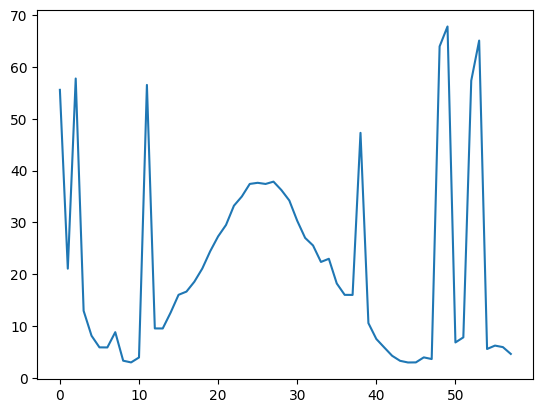

In [9]:
plt.plot(data)

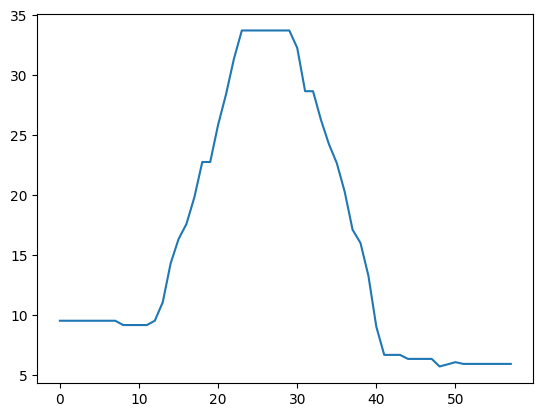

In [10]:
plt.plot(proc.medianFilter(data))
filteredData = proc.medianFilter(data)

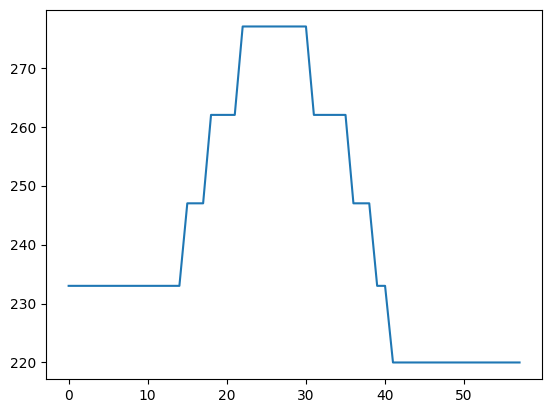

In [11]:
notes, frequencies = proc.discretizeNotes(filteredData)
plt.plot(frequencies)


In [13]:
buzPin = 12

pi = pigpio.pi(port = 8887)

for i in range(len(frequencies)):
    pi.hardware_PWM(buzPin, frequencies[i], int(0.5*1e6))
    time.sleep(0.05)
    pi.hardware_PWM(buzPin, 0, 0)